# How to combine spectra without interpolation.

A notebook to support and illustrate ideas in a forthcoming paper.

## Authors:
- **David W Hogg** (NYU) (MPIA) (Flatiron)
- **Andy Casey** (Monash)

## To-Do:
- Define three data sets (good sampling, bad sampling, very bad sampling).
- Output plots for the paper as PNG or PDF and git commit them.
- Maybe add residual plots to the combined-spectrum plots? They could be added at y=0.
- Make a figure that shows dependence of output on input-data pixel spacing.
- Make a figure that shows empirical pixel-to-pixel covariances as a function of lag.
- These latter two projects require that we turn the end-to-end data generation into one single function call, we turn the *Forward Model (tm)* into one single function call, and we turn *Standard Practice (tm)* into one function call.

## Bugs:
- Uses `np.random.seed()` and not a random number generator object.
- Sometimes uses `j` where it should use `i`; notation should match the *LaTeX* file!
- *Sign* and *name* of *Delta x_i* not used correctly in plots or code.
- Currently the text doesn't explain the data generation process quite correctly (it involves an `exp()` call).

## Comments:
- The badness of *Standard Practice (tm)* relative to the *Forward Model (tm)* is a strong function of the sampling of the raw data. Like 0.65 R is way way worse than 0.75 R.

## Stretch goals:
- Execute on real individual-exposure *SDSS-V APOGEE* data, perhaps?

In [1]:
# imports and initialize seeds, fundamental constants
import numpy as np
import pylab as plt
import scipy.interpolate as interp
np.random.seed(42) # the second-most random number, after 17.
c = 299792458. # m / s
sqrt2pi = np.sqrt(2. * np.pi)

In [2]:
# plotting defaults
# has to be in its own cell?
plt.rc('figure', figsize=(6.0, 3.6), dpi=150, autolayout=True)
# plt.rc('text', usetex=True)

## Make a fake data set with `n_epoch` epochs.

In [3]:
# define high-level parameters, especially including spectrograph parameters
R = 1.35e5 # resolution
SNR = 15. # s/n ratio per pixel in the continuum
continuum_ivar = SNR ** 2 # inverse variance of the noise in the continuum
sigma_x = 1. / R # LSF sigma in x units
dx = 1. / (0.7 * R) # pixel spacing in the poorly sampled data; UNDER-SAMPLED!
x_min = 8.7000 # minimum ln wavelength
x_max = 8.7025 # maximum ln wavelength
lines_per_x = 2.0e4 # mean density (Poisson rate) of lines per unit ln wavelength
ew_max_x = 3.0e-5 # maximum equivalent width in x units
ew_power = 5.0 # power parameter in EW maker
badfrac = 0.01 # fraction of data to mark bad

In [4]:
# set up the line list for the true spectral model
x_margin = 1.e6/c # hoping no velocities are bigger than 1000 km/s
x_range = x_max - x_min + 2. * x_margin # make lines in a bigger x range than the data range
nlines = np.random.poisson(x_range * lines_per_x) # set the total number of lines
line_xs = (x_min - x_margin) + x_range * np.random.uniform(size=nlines)

In [5]:
# give those lines equivalent widths from a power-law distribution
line_ews = ew_max_x * np.random.uniform(size=nlines) ** ew_power # don't ask

In [6]:
# make the synthetic spectrum (spectral expectation), and also add noise

def oned_gaussian(dxs, sigma):
    return np.exp(-0.5 * dxs ** 2 / sigma ** 2) / (sqrt2pi * sigma)

def true_spectrum(xs, doppler, lxs=line_xs, ews=line_ews, sigma=sigma_x):
    """
    """
    return np.exp(-1. * np.sum(ews[None, :] *
                               oned_gaussian(xs[:, None] - doppler
                                             - lxs[None, :], sigma), axis=1))

def ivar(ys, continuum_ivar):
    return continuum_ivar / ys

def noisy_true_spectrum(xs, doppler, continuum_ivar):
    """
    """
    ys_true = true_spectrum(xs, doppler)
    y_ivars = ivar(ys_true, continuum_ivar)
    return  ys_true + np.random.normal(size=xs.shape) / np.sqrt(y_ivars), y_ivars

def doppler_information(xs, doppler, continuum_ivar, dx=0.5*dx):
    """
    # Bugs:
    - Horrifying numerical derivative!
    """
    dys_dx = (true_spectrum(xs, doppler + dx)
              - true_spectrum(xs, doppler - dx)) / (2. * dx)
    y_ivars = ivar(true_spectrum(xs, doppler), continuum_ivar)
    return np.sum(y_ivars * dys_dx ** 2)

In [7]:
# create true Doppler shifts on a sinusoid of epoch number
n_epochs = 16 # number of observations; should be called N
true_dopplers = (3.e4 / c) * np.cos(np.arange(n_epochs) / 3) # Doppler shifts in x; should be called Delta x

In [8]:
# now make the noisy fake data
xs = np.arange(x_min, x_max, dx) # pixel grid for single-epoch observations
n_pix = len(xs) # number of pixels in each observation; should be called M
ys = np.zeros((n_epochs, n_pix))
y_ivars = np.zeros((n_epochs, n_pix))
y_ivars_empirical = np.zeros((n_epochs, n_pix))
for j in range(n_epochs):
    ys[j], y_ivars[j] = noisy_true_spectrum(xs, true_dopplers[j], continuum_ivar)
    y_ivars_empirical[j] = ivar(ys[j], continuum_ivar)

In [9]:
# Make bad-pixel masks and badify some pixels.

def badify(yy):
    bady = 1. * yy
    bs = (np.random.uniform(size=len(bady)) > badfrac).astype(int)
    bs = np.minimum(bs, np.roll(bs, 1))
    bs = np.minimum(bs, np.roll(bs, -1))
    nbad = np.sum(bs < 0.5)
    if nbad > 0:
        bady[bs < 0.5] += 2. * np.random.uniform(size=nbad)
    return bs, bady

In [10]:
# badify, destructively (ie, over-writing the data, dangerously)
# BUG: ONLY RUN THIS ONCE HAHA
bs = np.zeros_like(ys).astype(int)
for j in range(n_epochs):
    bs[j], ys[j] = badify(ys[j])
print(np.sum((bs < 0.5), axis=-1))

[ 9  3  6  6  3 12  6  9  6  6  9  9  6  9  6  9]


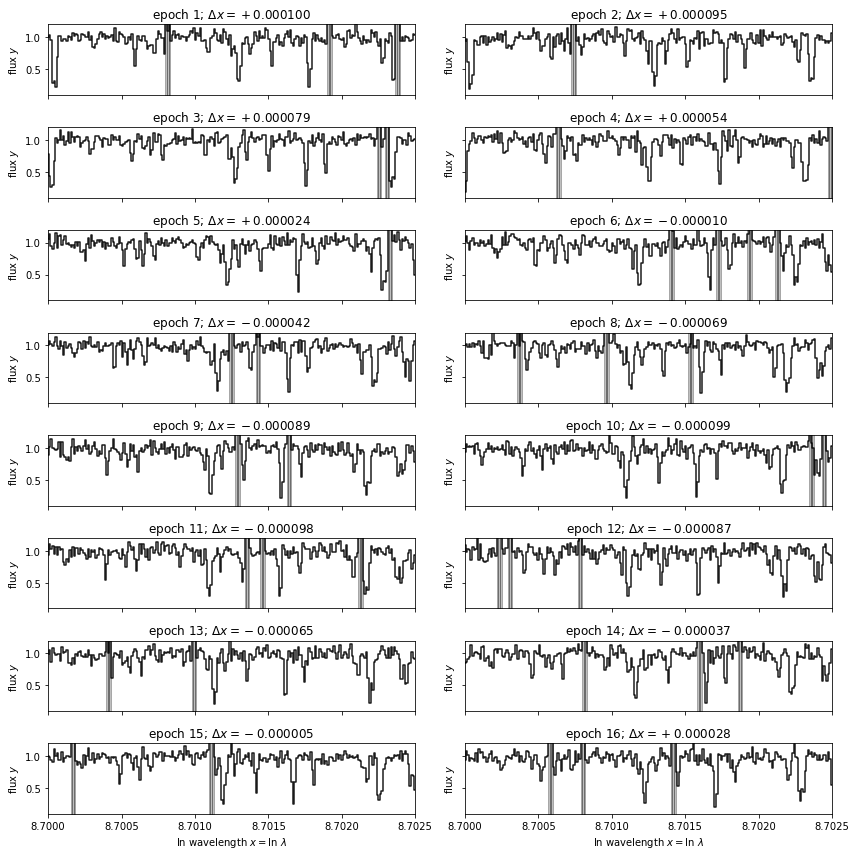

In [11]:
# show the input data
fig, axes = plt.subplots(n_epochs // 2, 2, sharex=True, sharey=True,
                         figsize=(12., 0.75 * n_epochs))
for j,ax in enumerate(axes.flatten()):
    ax.step(xs, ys[j], color="k", where="mid", alpha=0.9)
    ax.set_title("epoch {}; $\Delta x = {:+f}$".format(j + 1, true_dopplers[j]))
    ax.set_ylabel(r"flux $y$")
    for k in np.arange(len(ys[j]))[bs[j] < 0.5]:
        ax.fill_between([xs[k] - 0.5 * dx, xs[k] + 0.5 * dx],
                        [0., 0.], [2., 2.], color="k", alpha=0.25)
for j in range(2):
    axes[-1, j].set_xlabel(r"ln wavelength $x=\ln\,\lambda$")
plt.xlim(x_min, x_max)
ylim = (0.1, 1.2)
plt.ylim(*ylim)
plt.savefig("data.pdf")

Text(0.5, 1.0, 'epoch 7; $\\Delta x = -0.000042$')

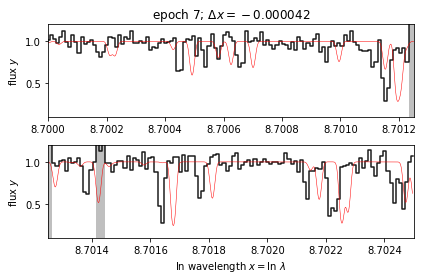

In [12]:
# zoom in on one epoch and compare it to the true template.
j = 6
fig, axes = plt.subplots(2, 1, sharex=False, sharey=True)
finexs = np.arange(np.min(xs), np.max(xs), 1. / (5. * R))
for ax in axes:
    ax.step(xs, ys[j], color="k", where="mid", alpha=0.9)
    ax.set_ylabel(r"flux $y$")
    ax.plot(finexs, true_spectrum(finexs, 0.), "r-", alpha=1.0, lw=0.5)
    ax.ticklabel_format(useOffset=False)
    for k in np.arange(len(ys[j]))[bs[j] < 0.5]:
        ax.fill_between([xs[k] - 0.5 * dx, xs[k] + 0.5 * dx],
                        [-1., -1.], [2., 2.], color="k", alpha=0.25, ec="none")

axes[0].set_xlim(8.7000, 8.70125)
axes[1].set_xlim(8.70125, 8.7025)
axes[0].set_ylim(*ylim)
axes[1].set_xlabel(r"ln wavelength $x=\ln\,\lambda$")
axes[0].set_title("epoch {}; $\Delta x = {:+f}$".format(j + 1, true_dopplers[j]))

## Set up output parameters and functions for combined spectrum.

Notes:
- If you set `P = Mstar` then the Fourier model can interpolate anything.
- If you set `P = Mstar // 2 + 1` then the Fourier model will be band-limited at the Nyquist frequency. This is cool but it shows ringing / wiggles.

In [13]:
# Set the pixel grid and model complexity for the combined spectrum
dxstar = 1. / (1.2 * R) # output pixel grid spacing
xstar = np.arange(x_min - 1.5 * dxstar, x_max + 2.0 * dxstar, dxstar) # output pixel grid
Mstar = len(xstar) # number of output pixels
P = Mstar # number of Fourier modes (ish)
print(Mstar, P, xstar.shape)

409 409 (409,)


In [14]:
def design_matrix(xs, L=(x_max - x_min)):
    """
    Take in a set of x positions and return the Fourier design matrix.

    ## Bugs:
    - Needs comment header.
    
    ## Comments:
    - The code looks different from the paper because Python zero-indexes.
    - This could be replaced with something that makes use of finufft.
    """
    X = np.ones_like(xs).reshape(len(xs), 1)
    for j in range(1, P):
        if j % 2 == 0:
            X = np.concatenate((X, np.cos(np.pi * j * xs / L)[:, None]), axis=1)
        else:
            X = np.concatenate((X, np.sin(np.pi * (j + 1) * xs / L)[:, None]), axis=1)
    return X

In [15]:
def pack_matrices(xs, ys):
    """
    Rearrange data into big matrices for `lstsq()`.

    ## Bugs:
    - Needs comment header.
    """
    XX = np.array([])
    YY = np.array([])
    for bb, yy, Dx in zip(bs, ys, true_dopplers):
        x_rest = (xs - Dx)[bb > 0.5]
        I = np.logical_and(x_rest > x_min, x_rest < x_max)
        YY = np.append(YY, yy[bb > 0.5][I])
        XX = np.append(XX, x_rest[I])
    return design_matrix(XX), YY

In [16]:
X, Y = pack_matrices(xs, ys)
print(X.shape, Y.shape)

(3582, 409) (3582,)


## Make the combined spectrum and compare to the truth.

In [17]:
# Now do the least-square fit
Xstar = design_matrix(xstar) # design matrix
print(Xstar.shape)
thetahat, foo, bar, whatevs = np.linalg.lstsq(X, Y, rcond=None) # solve using `lstsq()`.
print(thetahat.shape)
ystar = Xstar @ thetahat # make prediction / combined spectrum.
print(ystar.shape)

(409, 409)
(409,)
(409,)


Text(0.5, 1.0, 'Forward Model (tm) combined spectrum')

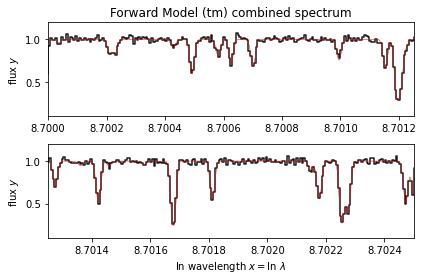

In [18]:
# compare the combined spectrum to the true template.
fig, axes = plt.subplots(2, 1, sharex=False, sharey=True)
for ax in axes:
    ax.step(xstar, ystar, color="k", where="mid", alpha=0.9)
    ax.set_ylabel(r"flux $y$")
    ax.plot(finexs, true_spectrum(finexs, 0.), "r-", alpha=1.0, lw=0.5)
    ax.ticklabel_format(useOffset=False)
axes[0].set_xlim(8.7000, 8.70125)
axes[1].set_xlim(8.70125, 8.7025)
axes[0].set_ylim(*ylim)
axes[1].set_xlabel(r"ln wavelength $x=\ln\,\lambda$")
axes[0].set_title("Forward Model (tm) combined spectrum")

## Implement a version of *Standard Practice (tm)*

In [19]:
# interpolate the data and the masks; deal with edges.
# Note that we are being very conservative with the mask.
yprimes = np.zeros((n_epochs, len(xstar)))
bprimes = np.zeros_like(yprimes).astype(int)
ikwargs = {"kind": "cubic", "fill_value": "extrapolate"}
for j in range(n_epochs):
    yprimes[j] = interp.interp1d(xs - true_dopplers[j], ys[j],
                                  **ikwargs)(xstar)
    bprimes[j] = (np.abs(interp.interp1d(xs - true_dopplers[j], bs[j],
                                 **ikwargs)(xstar) - 1.) < 0.01).astype(int)
    bprimes[j][xstar < (min(xs) - true_dopplers[j])] = 0
    bprimes[j][xstar > (max(xs) - true_dopplers[j])] = 0

Text(0.5, 1.0, 'epoch 7, interpolated to rest frame')

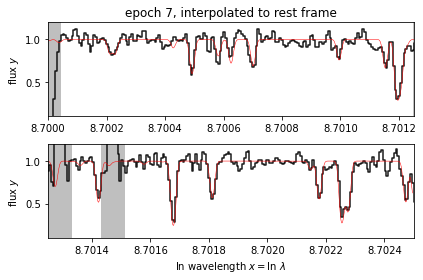

In [20]:
j = 6
fig, axes = plt.subplots(2, 1, sharex=False, sharey=True)
for ax in axes:
    ax.step(xstar, yprimes[j], color="k", where="mid", alpha=0.9)
    ax.set_ylabel(r"flux $y$")
    ax.plot(finexs, true_spectrum(finexs, 0.), "r-", alpha=1.0, lw=0.5)
    ax.ticklabel_format(useOffset=False)
    for k in np.arange(len(yprimes[j]))[bprimes[j] < 0.5]:
        ax.fill_between([xstar[k] - 0.5 * dxstar, xstar[k] + 0.5 * dxstar],
                        [0., 0.], [2., 2.], color="k", alpha=0.25, ec="none")
axes[0].set_xlim(8.7000, 8.70125)
axes[1].set_xlim(8.70125, 8.7025)
axes[0].set_ylim(*ylim)
axes[1].set_xlabel(r"ln wavelength $x=\ln\,\lambda$")
axes[0].set_title("epoch {}, interpolated to rest frame".format(j + 1))

In [21]:
# do the combination
ystar_sp = np.sum(yprimes * bprimes, axis=0) / np.sum(bprimes, axis=0)

Text(0.5, 1.0, 'Standard Practice (tm) combined spectrum')

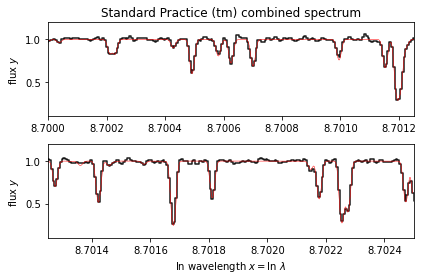

In [22]:
# compare the combined spectrum to the true template.
fig, axes = plt.subplots(2, 1, sharex=False, sharey=True)
for ax in axes:
    ax.step(xstar, ystar_sp, color="k", where="mid", alpha=0.9)
    ax.set_ylabel(r"flux $y$")
    ax.plot(finexs, true_spectrum(finexs, 0.), "r-", alpha=1.0, lw=0.5)
    ax.ticklabel_format(useOffset=False)
axes[0].set_xlim(8.7000, 8.70125)
axes[1].set_xlim(8.70125, 8.7025)
axes[0].set_ylim(*ylim)
axes[1].set_xlabel(r"ln wavelength $x=\ln\,\lambda$")
axes[0].set_title("Standard Practice (tm) combined spectrum")

## TODO: Make results as a function of input-data pixel scale

## TODO: Empirically compute pixel covariances as a function of lag